In [46]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import boto3
s3 = boto3.client('s3')
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve
from photutils.segmentation import SourceFinder, make_2dgaussian_kernel
from photutils.utils import ImageDepth
import dja_sepp

In [77]:
home = "/home/aurelien/DAWN/DJA-SEpp"
field = 'gdn-grizli-v7.3'
filter = 'f277w'

In [42]:
img = dja_sepp.s3.find_files(bucket='grizli-v2', 
                             path='JwstMosaics/v7', 
                             regex=f"{field}-{filter}-clear_drc_sci.+")[0]
print(img)

gdn-grizli-v7.3-f277w-clear_drc_sci.fits.gz


In [47]:
folder = f"{home}/fields/{field}/image"
os.makedirs(folder, exist_ok=True)
s3.download_file('grizli-v2', f"JwstMosaics/v7/{img}", f"{folder}/{img}")

In [48]:
hdul = fits.open(glob.glob(f"{home}/fields/{field}/image/*{filter}*sci*")[0], memmap=True)
hdu = hdul[0]

In [49]:
wcs = WCS(hdu.header)
footprint = wcs.calc_footprint()

In [50]:
center_fp = footprint.mean(axis=0)
center = SkyCoord(center_fp[0], center_fp[1], frame='icrs', unit='deg')

In [85]:
size=u.Quantity((5.0,5.0), u.arcmin)

cutout = Cutout2D(hdu.data, 
                  position=center, size=size, 
                  wcs=wcs,
                  mode='partial', fill_value=0.0)

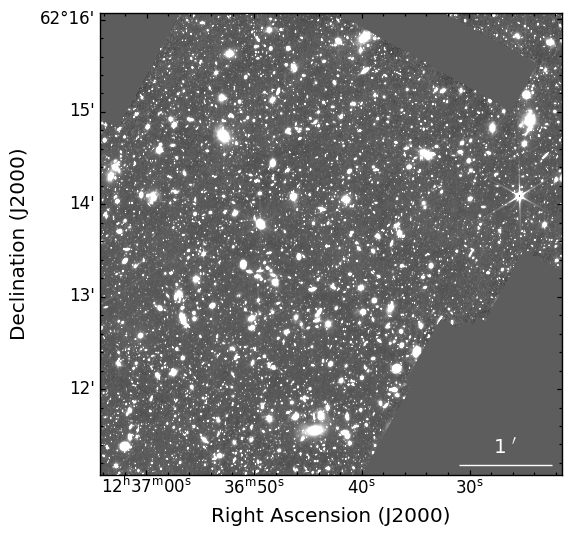

In [86]:
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':cutout.wcs})
norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
# norm = ImageNormalize(cutout.data, interval=MinMaxInterval(), stretch=LogStretch())
ax.imshow(cutout.data, cmap='gray', origin='lower', norm=norm)
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
dja_sepp.utils.add_good_scalebar(ax, cutout.wcs)
plt.show()

In [87]:
data = cutout.data
kernel = make_2dgaussian_kernel(3.0, size=5)
convolved_data = convolve(data, kernel)

In [88]:
npixels = 5
threshold = 0.1
finder = SourceFinder(npixels=npixels, progress_bar=True)
segment_map = finder(convolved_data, threshold)
mask = segment_map.make_source_mask()

Deblending:   0%|          | 0/4174 [00:00<?, ?it/s]

In [89]:
radius = 5
zeropoint = (1*u.nJy).to(u.ABmag).value
depth = ImageDepth(radius, nsigma=5.0, napers=500, niters=2,
                   mask_pad=20, overlap=False, seed=123,
                   zeropoint=zeropoint, progress_bar=True)
limits = depth(10*data, mask)
print(np.array(limits))  

Image Depths:   0%|          | 0/2 [00:00<?, ?it/s]

[ 8.83456284 29.03453734]


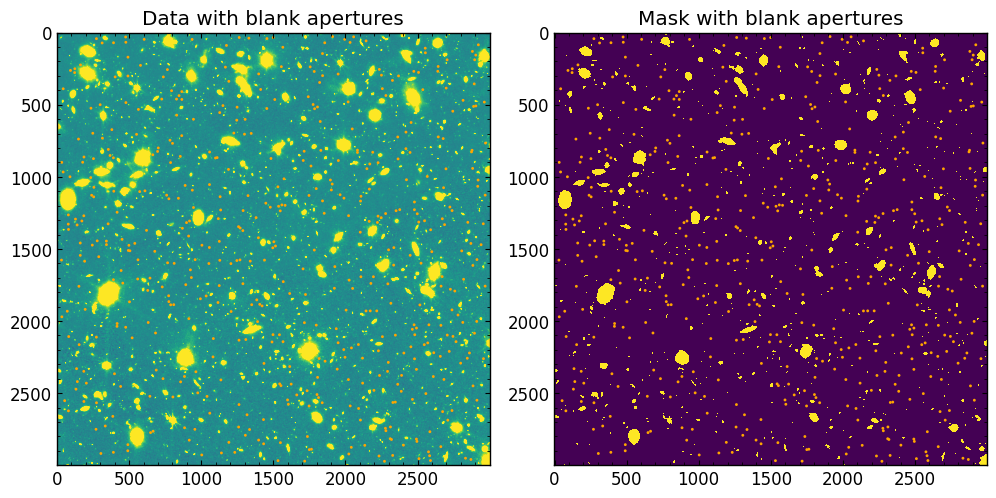

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
norm = ImageNormalize(data, interval=ZScaleInterval())
ax[0].imshow(data, norm=norm)
color = 'orange'
depth.apertures[0].plot(ax[0], color=color)
ax[0].set_title('Data with blank apertures')
ax[1].imshow(mask, interpolation='none')
depth.apertures[0].plot(ax[1], color=color)
ax[1].set_title('Mask with blank apertures')

plt.subplots_adjust(left=0.05, right=0.98, bottom=0.05, top=0.95,
                    wspace=0.15)